# Imports and libraries

please run pip install -r requirements.txt <br>
please ensure the whole project is under the path 'Group10_project' case sensitive <br>
'i.e. ..\\Group10_project\\src\\'

In [1]:
import os

import numpy as np

import pandas as pd
pd.options.display.float_format = "{:,.2f}".format

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

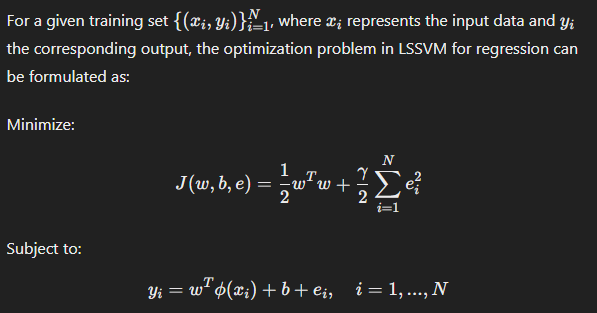

In [2]:
def getProjectRoot():
    REPO_NAME = "Group10_project"
    currentPath = os.getcwd()
    projectRoot = currentPath.split(REPO_NAME)[0] + REPO_NAME +"\\"

    return projectRoot

def getDataPaths(dataPath):
    for root, dirs, files in os.walk(dataPath):
        for file in files:
            # Get the full path to the file
            file_path = os.path.join(root, file)
            print(file_path)


## data processing helpers


In [3]:
def get_date_range_split(df, start_date, end_date, target_column, date_column = "DATETIME"):
    if date_column:
        df[date_column] = pd.to_datetime(df[date_column])
        df_filtered = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    else:
        df.index = pd.to_datetime(df.index)
        df_filtered = df[(df.index >= start_date) & (df.index <= end_date)]

    # Split into X_test and y_test
    X_test = df_filtered.drop(columns=[target_column, date_column])
    y_test = df_filtered[target_column]
    
    X_test = X_test.to_numpy()
    scaler = StandardScaler()
    X_test = scaler.fit_transform(X_test)

    return X_test, y_test

## post-prediction helpers

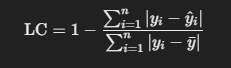

In [4]:
def getEvaluationMetrics(y_test, y_pred):
    total_demand_mean = y_test.mean()

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / total_demand_mean
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    # Calculate Willmott's Index of Agreement (WI)
    def willmott_index(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((np.abs(y_pred - mean_observed) + np.abs(y_true - mean_observed)) ** 2)
        return 1 - (numerator / denominator)

    wi = willmott_index(y_test, y_pred)

    # Calculate Nash–Sutcliffe Efficiency (NSE) coefficient
    def nash_sutcliffe_efficiency(y_true, y_pred):
        mean_observed = np.mean(y_true)
        numerator = np.sum((y_true - y_pred) ** 2)
        denominator = np.sum((y_true - mean_observed) ** 2)
        return 1 - (numerator / denominator)

    nse = nash_sutcliffe_efficiency(y_test, y_pred)

    # calculate the Legates & McCabes Index (ELM)
    def getELM(y_test, y_pred):
        y_mean = np.mean(y_test)
        numerator = np.sum(np.abs(y_pred - y_test))
        denominator = np.sum(np.abs(y_test -y_mean))
        ELM_index = 1-(numerator/denominator)
        return ELM_index

    elm = getELM(y_test, y_pred)

    print(f'MAE: {mae:.2f}')
    print(f'Mean Squared Error (Regression): {mse:.2f}')
    print(f'R^2 Score (Regression): {r2:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'RRMSE: {rrmse:.4f}')
    print(f'Nash–Sutcliffe efficiency coefficient: {nse:.2f}')
    print(f'Willmott index: {wi:.2f}')
    print(f'MAPE is: {mape:.2f}')
    print(f'ELM is :{elm:.2f}')

def getPlots(y_test, y_pred, residuals = False):
    # plots
    # pred vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='Actual', color='b')
    plt.plot(np.arange(len(y_pred)), y_pred, label='Predicted', color='r')
    plt.xlabel('Time')
    plt.ylabel('Total Demand')
    plt.title('LSSVM Time Series Forecasting - Actual vs Predicted')
    plt.legend()
    plt.show()

    if(residuals):
        # residuals
        residuals = y_test - y_pred
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(residuals)), residuals, label='Residuals', color='g')
        plt.axhline(0, color='k', linestyle='--')
        plt.xlabel('Time')
        plt.ylabel('Residuals')
        plt.title('Residuals of LSSVM Time Series Forecasting')
        plt.show()

## LSSVM Classes

In [5]:
class LSSVMRegressor:
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma

    def _linear_kernel(self, X1, X2):
        return np.dot(X1, X2.T)

    def _rbf_kernel(self, X1, X2):
        sq_dists = np.sum(X1**2, axis=1).reshape(-1,1) + \
                   np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-sq_dists / (2 * self.sigma**2))

    def fit(self, X, y):
        n_samples = X.shape[0]
        y = y.reshape(-1, 1)
        if self.kernel == 'linear':
            K = self._linear_kernel(X, X)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, X)

        #Omega = K + np.eye(n_samples) / self.gamma
        Omega = K + self.gamma * np.eye(n_samples)

        # Construct matrices for the linear system
        ones = np.ones((n_samples, 1))
        A = np.block([[0, ones.T],
                      [ones, Omega]])
        B = np.vstack([0, y])

        # Solve the linear system
        solution = np.linalg.solve(A, B)
        self.b = solution[0]
        self.alpha = solution[1:].flatten()
        self.X_train = X

    def predict(self, X):
        if self.kernel == 'linear':
            K = self._linear_kernel(X, self.X_train)
        elif self.kernel == 'rbf':
            K = self._rbf_kernel(X, self.X_train)
        predictions = np.dot(K, self.alpha) + self.b
        return predictions.flatten()

# Wrapper for GridSearchCV
class LSSVMRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, gamma=1.0, kernel='linear', sigma=1.0):
        self.gamma = gamma
        self.kernel = kernel
        self.sigma = sigma
        self.model = LSSVMRegressor(gamma=self.gamma, kernel=self.kernel, sigma=self.sigma)

    def fit(self, X, y):
        self.model.gamma = self.gamma
        self.model.kernel = self.kernel
        self.model.sigma = self.sigma
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Data assets

In [6]:
projRoot = getProjectRoot()
print(getDataPaths(projRoot + "\\data\\"))
print(getDataPaths(projRoot + "\\extracted_data\\"))

f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\a.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\b.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\c.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\Australia\d.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partaa
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\forecastdemand_nsw.csv.zip.partab
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\temperature_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\NSW\totaldemand_nsw.csv.zip
f:\UNSW Master of Data Science\ZZSC9020 Capstone\Group10_project\\data\SILO\40842 BRISBANE.csv
f:\UNSW Master of Data Science\ZZSC9020

# Data loading

In [7]:
rollingWindowNSW = pd.read_csv(projRoot + "data\\SILO\\NSW_Rolling_Data.csv")
rollingWindowNSW = rollingWindowNSW.dropna()
print(rollingWindowNSW.shape)
rollingWindowNSW.columns

(4091, 19)


Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH', 'bushfire', 'flood', 'temp_change', 'high_temp_change',
       'humid_change', 'high_humid_change', 'rain_change', 'high_rain_change',
       'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week'],
      dtype='object')

In [8]:
rollingWindowQLD = pd.read_csv(projRoot + "data\SILO\QLD_Rolling_Data.csv")
rollingWindowQLD = rollingWindowQLD.dropna()
print(rollingWindowQLD.shape)
rollingWindowQLD.columns

(4087, 19)


Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH', 'bushfire', 'flood', 'temp_change', 'high_temp_change',
       'humid_change', 'high_humid_change', 'rain_change', 'high_rain_change',
       'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week'],
      dtype='object')

In [9]:
dailyMergedNSW = pd.read_csv(projRoot + "data\\SILO\\daily_merged_nsw.csv")
dailyMergedNSW = dailyMergedNSW.dropna()
dailyMergedNSW['DATETIME'] = pd.to_datetime(dailyMergedNSW['DATETIME'])
print(dailyMergedNSW.shape)
dailyMergedNSW.columns

(4092, 8)


Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH'],
      dtype='object')

data considered loaded at this point checking the data for anychanges made before continuing

In [10]:
# you can change datasets to run against here using:
# data = rollingWindowNSW for example
data = rollingWindowQLD
data.describe()

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,bushfire,flood,temp_change,high_temp_change,humid_change,high_humid_change,rain_change,high_rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
count,"4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00"
mean,"6,026.58",20.36,2.86,5.42,18.93,17.40,70.33,0.56,0.02,-0.00,0.00,0.00,0.28,0.00,0.12,0.84,0.37,0.03
std,496.88,4.22,10.28,2.56,6.93,5.62,11.79,0.50,0.15,1.36,0.06,11.73,0.45,12.25,0.32,0.37,0.48,0.16
min,"4,845.57",9.99,0.00,0.00,1.10,2.80,12.70,0.00,0.00,-6.46,0.00,-60.10,0.00,-167.00,0.00,0.00,0.00,0.00
25%,"5,691.77",16.78,0.00,3.40,13.90,13.50,65.20,0.00,0.00,-0.72,0.00,-5.10,0.00,0.00,0.00,1.00,0.00,0.00
50%,"5,962.39",20.78,0.00,5.20,18.30,17.60,72.45,1.00,0.00,0.10,0.00,0.50,0.00,0.00,0.00,1.00,0.00,0.00
75%,"6,297.84",23.91,0.80,7.20,24.70,21.40,78.20,1.00,0.00,0.82,0.00,6.20,1.00,0.00,0.00,1.00,1.00,0.00
max,"7,993.98",32.18,174.60,32.80,33.20,32.40,97.15,1.00,1.00,6.22,1.00,55.00,1.00,130.00,1.00,1.00,1.00,1.00


# Exploratory data analysis

EDA of the DataFrame 'data' is performed here. No transformations or modifications are made during this stage

## Data summary

In [11]:
summary_stats = data.describe()
summary_stats

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,bushfire,flood,temp_change,high_temp_change,humid_change,high_humid_change,rain_change,high_rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
count,"4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00"
mean,"6,026.58",20.36,2.86,5.42,18.93,17.40,70.33,0.56,0.02,-0.00,0.00,0.00,0.28,0.00,0.12,0.84,0.37,0.03
std,496.88,4.22,10.28,2.56,6.93,5.62,11.79,0.50,0.15,1.36,0.06,11.73,0.45,12.25,0.32,0.37,0.48,0.16
min,"4,845.57",9.99,0.00,0.00,1.10,2.80,12.70,0.00,0.00,-6.46,0.00,-60.10,0.00,-167.00,0.00,0.00,0.00,0.00
25%,"5,691.77",16.78,0.00,3.40,13.90,13.50,65.20,0.00,0.00,-0.72,0.00,-5.10,0.00,0.00,0.00,1.00,0.00,0.00
50%,"5,962.39",20.78,0.00,5.20,18.30,17.60,72.45,1.00,0.00,0.10,0.00,0.50,0.00,0.00,0.00,1.00,0.00,0.00
75%,"6,297.84",23.91,0.80,7.20,24.70,21.40,78.20,1.00,0.00,0.82,0.00,6.20,1.00,0.00,0.00,1.00,1.00,0.00
max,"7,993.98",32.18,174.60,32.80,33.20,32.40,97.15,1.00,1.00,6.22,1.00,55.00,1.00,130.00,1.00,1.00,1.00,1.00


## Time series plot

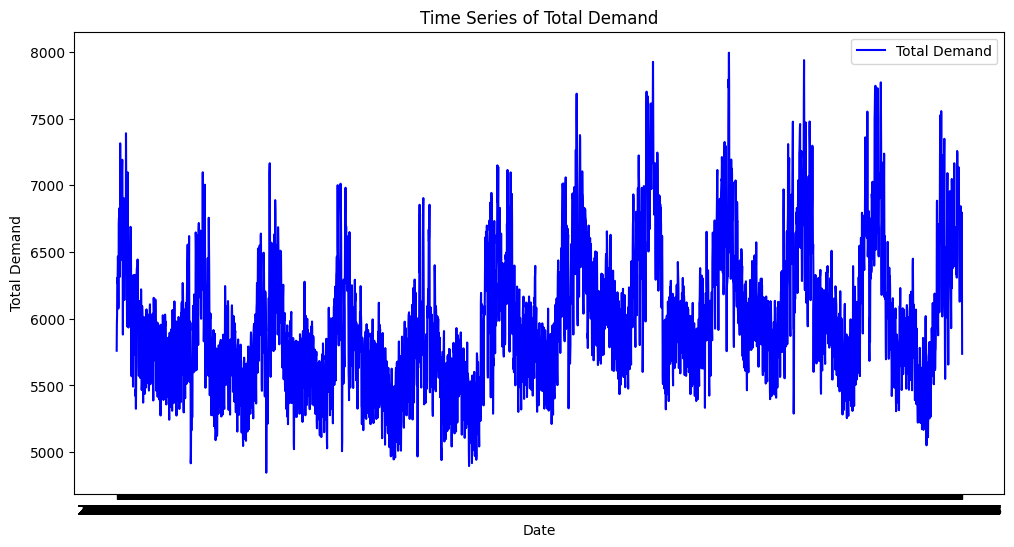

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data['DATETIME'], data['TOTALDEMAND'], label='Total Demand', color='b')
plt.xlabel('Date')
plt.ylabel('Total Demand')
plt.title('Time Series of Total Demand')
plt.legend()
plt.show()


## Correlation map

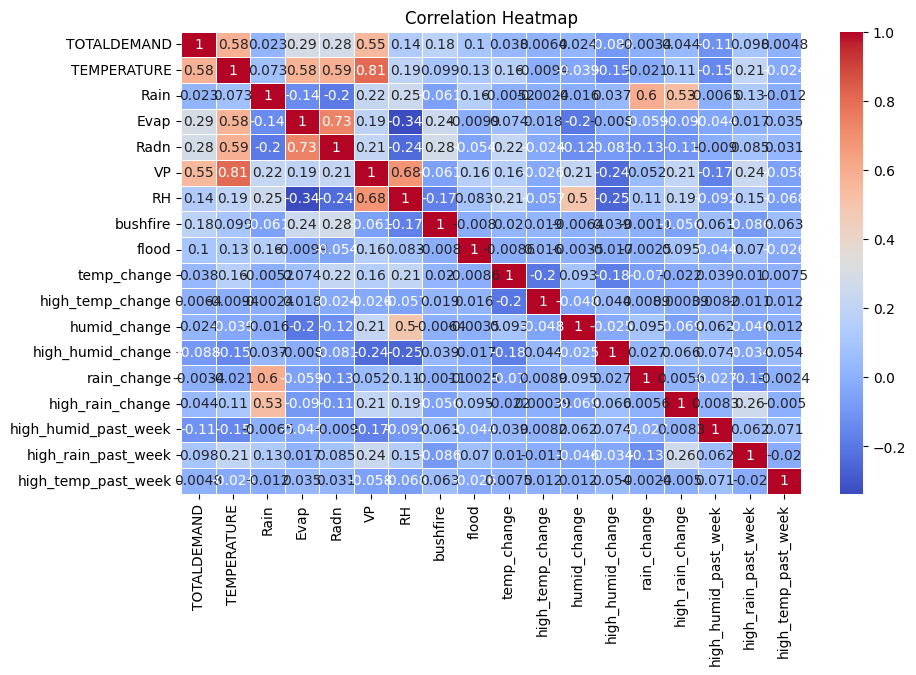

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Autocorrelation and partial autocorrelation for TOTALDEMAND

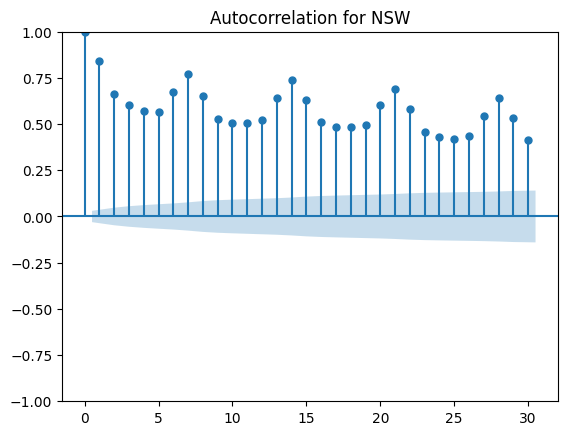

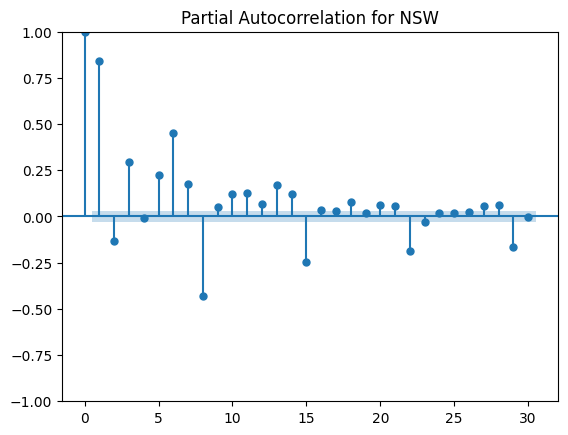

In [14]:
state_id = 'NSW'
plot_acf(data['TOTALDEMAND'], lags=30, title=f'Autocorrelation for {state_id}')
plot_pacf(data['TOTALDEMAND'], lags=30, title=f'Partial Autocorrelation for {state_id}')
plt.show()

# Feature engineering

Based on EDA the DataFrame 'data' is modified with engineered features

In [15]:
data.describe()

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,bushfire,flood,temp_change,high_temp_change,humid_change,high_humid_change,rain_change,high_rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
count,"4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00","4,087.00"
mean,"6,026.58",20.36,2.86,5.42,18.93,17.40,70.33,0.56,0.02,-0.00,0.00,0.00,0.28,0.00,0.12,0.84,0.37,0.03
std,496.88,4.22,10.28,2.56,6.93,5.62,11.79,0.50,0.15,1.36,0.06,11.73,0.45,12.25,0.32,0.37,0.48,0.16
min,"4,845.57",9.99,0.00,0.00,1.10,2.80,12.70,0.00,0.00,-6.46,0.00,-60.10,0.00,-167.00,0.00,0.00,0.00,0.00
25%,"5,691.77",16.78,0.00,3.40,13.90,13.50,65.20,0.00,0.00,-0.72,0.00,-5.10,0.00,0.00,0.00,1.00,0.00,0.00
50%,"5,962.39",20.78,0.00,5.20,18.30,17.60,72.45,1.00,0.00,0.10,0.00,0.50,0.00,0.00,0.00,1.00,0.00,0.00
75%,"6,297.84",23.91,0.80,7.20,24.70,21.40,78.20,1.00,0.00,0.82,0.00,6.20,1.00,0.00,0.00,1.00,1.00,0.00
max,"7,993.98",32.18,174.60,32.80,33.20,32.40,97.15,1.00,1.00,6.22,1.00,55.00,1.00,130.00,1.00,1.00,1.00,1.00


### Add lag variables

before adding the lagging variables, we need to check the correlation of various lags with the target variable

maximum correlation at:0.58 at lag of 0 for feature: TEMPERATURE
maximum correlation at:0.08 at lag of 353 for feature: Rain
maximum correlation at:0.37 at lag of 37 for feature: Evap
maximum correlation at:0.40 at lag of 48 for feature: Radn
maximum correlation at:0.52 at lag of 0 for feature: VP
maximum correlation at:0.13 at lag of 300 for feature: RH


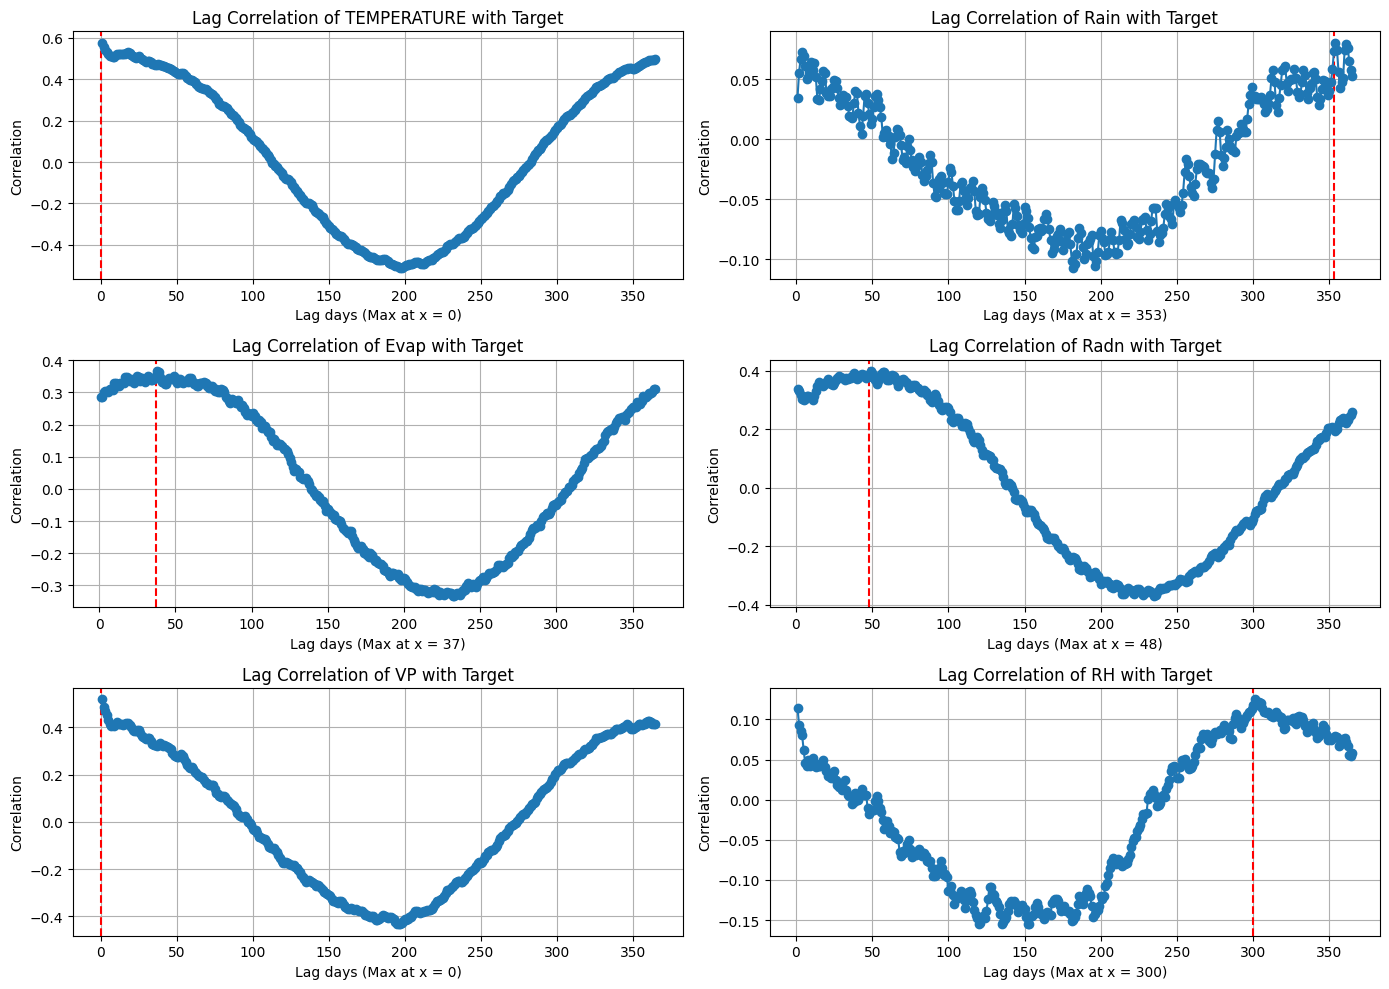

In [16]:
# Number of lags to compute
def getLagCorrelationMatrix(df):
    lagged_data = {}
    num_lags = 365
    targetvar = 'TOTALDEMAND'
    # Create lagged features for each feature and store in a dictionary
    features = ['TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP', 'RH']
    for feature in features:
        for lag in range(1, num_lags + 1):
            lagged_data[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

    # Concatenate all lagged features into a new DataFrame
    lagged_df = pd.concat(lagged_data, axis=1)

    # Drop NaN values caused by lagging
    lagged_df.dropna(inplace=True)
    df = df.loc[lagged_df.index]

    # Initialize a figure with 2x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    # Loop through each feature and plot lagged correlations

    selectedLags = dict()

    for i, feature in enumerate(features):
        # Calculate correlations for the current feature
        lagged_correlations = []
        for lag in range(1, num_lags + 1):
            correlation = lagged_df[f'{feature}_lag_{lag}'].corr(df[targetvar])
            lagged_correlations.append(correlation)
        

        max_x = lagged_correlations.index(max(lagged_correlations))
        max_y = max(lagged_correlations)
        print(f"maximum correlation at:{max_y:.2f}" +
              f" at lag of {max_x} for feature: {feature}")
        
        selectedLags[feature] = max_x

        # Get subplot axes
        ax = axes[i // 2, i % 2]
        # Plot the correlations
        ax.axvline(x=max_x, color='red', linestyle='--')
        ax.plot(range(1, num_lags + 1), lagged_correlations, marker='o')
        ax.set_title(f'Lag Correlation of {feature} with Target')
        ax.set_xlabel(f'Lag days (Max at x = {max_x:.0f})')
        ax.set_ylabel('Correlation')
        ax.grid(True)

    return selectedLags

selectedLags = getLagCorrelationMatrix(data)
plt.tight_layout()
plt.show()

In [17]:
selectedLags

for feature in selectedLags:
    lag = selectedLags[feature]
    data[f'{feature}_lag_{lag}'] = data['TOTALDEMAND'].shift(lag)

print('\n'.join(data.columns))

DATETIME
TOTALDEMAND
TEMPERATURE
Rain
Evap
Radn
VP
RH
bushfire
flood
temp_change
high_temp_change
humid_change
high_humid_change
rain_change
high_rain_change
high_humid_past_week
high_rain_past_week
high_temp_past_week
TEMPERATURE_lag_0
Rain_lag_353
Evap_lag_37
Radn_lag_48
VP_lag_0
RH_lag_300


In [18]:
# TODO: generate lag features using autocorrelation plots and correlation analysis
lagSteps = [1,7,14,28]


for lag in lagSteps:
    data[f'TOTALDEMAND_lag_{lag}'] = data['TOTALDEMAND'].shift(lag)
    data[f'TEMPERATURE_lag_{lag}'] = data['TEMPERATURE'].shift(lag)
    data[f'Rain_lag_{lag}'] = data['Rain'].shift(lag)
    data[f'Evap_lag_{lag}'] = data['Evap'].shift(lag)
    data[f'rand_lag_{lag}'] = data['Radn'].shift(lag)
    data[f'rh_lag_{lag}'] = data['RH'].shift(lag)

print('\n'.join(data.columns))

DATETIME
TOTALDEMAND
TEMPERATURE
Rain
Evap
Radn
VP
RH
bushfire
flood
temp_change
high_temp_change
humid_change
high_humid_change
rain_change
high_rain_change
high_humid_past_week
high_rain_past_week
high_temp_past_week
TEMPERATURE_lag_0
Rain_lag_353
Evap_lag_37
Radn_lag_48
VP_lag_0
RH_lag_300
TOTALDEMAND_lag_1
TEMPERATURE_lag_1
Rain_lag_1
Evap_lag_1
rand_lag_1
rh_lag_1
TOTALDEMAND_lag_7
TEMPERATURE_lag_7
Rain_lag_7
Evap_lag_7
rand_lag_7
rh_lag_7
TOTALDEMAND_lag_14
TEMPERATURE_lag_14
Rain_lag_14
Evap_lag_14
rand_lag_14
rh_lag_14
TOTALDEMAND_lag_28
TEMPERATURE_lag_28
Rain_lag_28
Evap_lag_28
rand_lag_28
rh_lag_28


### Add date time variables

In [19]:
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data['DAY'] = data['DATETIME'].dt.day_of_year
data['MONTH'] = data['DATETIME'].dt.month
data['YEAR'] = data['DATETIME'].dt.year
data['day_of_week'] = data['DATETIME'].dt.dayofweek
data['DAY_lag_250'] = data['DAY'].shift(250)
data['MONTH_lag_250'] = data['MONTH'].shift(250)
data['fourier_sin_day'] = np.sin(2 * np.pi * data['DAY'] / 365)
data['fourier_cos_day'] = np.cos(2 * np.pi * data['DAY'] / 365)
data['fourier_sin_month'] = np.sin(2 * np.pi * data['MONTH'] / 12)
data['fourier_cos_month'] = np.cos(2 * np.pi * data['MONTH'] / 12)

## Data scaling

In [20]:
exclude_columns = [col for col in data.columns if 'high' in col]
exclude_columns.append('bushfire')
exclude_columns.append('flood')
exclude_columns.append('DATETIME')
exclude_columns.append('TOTALDEMAND')
exclude_columns

['high_temp_change',
 'high_humid_change',
 'high_rain_change',
 'high_humid_past_week',
 'high_rain_past_week',
 'high_temp_past_week',
 'bushfire',
 'flood',
 'DATETIME',
 'TOTALDEMAND']

In [21]:
columns_to_scale = [col for col in data.columns if col not in exclude_columns]
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

In [22]:
data.dropna(inplace=True)
data.describe()

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,bushfire,flood,temp_change,...,DAY,MONTH,YEAR,day_of_week,DAY_lag_250,MONTH_lag_250,fourier_sin_day,fourier_cos_day,fourier_sin_month,fourier_cos_month
count,"3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00",...,"3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00","3,734.00"
mean,"6,030.24",0.01,-0.01,0.03,0.03,-0.01,-0.02,0.60,0.02,0.00,...,0.00,0.00,0.15,-0.00,0.03,0.03,0.00,0.01,0.00,0.01
std,504.87,1.00,0.98,1.01,0.99,1.00,1.01,0.49,0.16,1.00,...,1.00,1.00,0.91,1.00,0.99,0.99,1.00,1.00,1.00,1.00
min,"4,845.57",-2.44,-0.28,-2.12,-2.57,-2.60,-4.89,0.00,0.00,-4.75,...,-1.69,-1.56,-1.58,-1.50,-1.69,-1.56,-1.44,-1.43,-1.43,-1.43
25%,"5,689.12",-0.83,-0.28,-0.71,-0.71,-0.69,-0.46,0.00,0.00,-0.53,...,-0.89,-0.99,-0.65,-1.00,-0.80,-0.69,-0.99,-1.00,-0.72,-0.72
50%,"5,962.28",0.11,-0.28,-0.09,-0.05,0.02,0.15,1.00,0.00,0.07,...,-0.01,-0.12,0.27,-0.00,0.01,-0.11,0.02,0.03,-0.02,-0.01
75%,"6,307.63",0.85,-0.22,0.78,0.85,0.71,0.64,1.00,0.00,0.60,...,0.88,0.74,0.89,1.00,0.89,0.76,0.99,1.00,1.21,1.21
max,"7,993.98",2.80,16.71,10.71,2.06,2.67,2.27,1.00,1.00,4.57,...,1.75,1.60,1.82,1.50,1.78,1.63,1.40,1.39,1.40,1.40


## Data summary before training

In [23]:
print('\n'.join(data.columns))

DATETIME
TOTALDEMAND
TEMPERATURE
Rain
Evap
Radn
VP
RH
bushfire
flood
temp_change
high_temp_change
humid_change
high_humid_change
rain_change
high_rain_change
high_humid_past_week
high_rain_past_week
high_temp_past_week
TEMPERATURE_lag_0
Rain_lag_353
Evap_lag_37
Radn_lag_48
VP_lag_0
RH_lag_300
TOTALDEMAND_lag_1
TEMPERATURE_lag_1
Rain_lag_1
Evap_lag_1
rand_lag_1
rh_lag_1
TOTALDEMAND_lag_7
TEMPERATURE_lag_7
Rain_lag_7
Evap_lag_7
rand_lag_7
rh_lag_7
TOTALDEMAND_lag_14
TEMPERATURE_lag_14
Rain_lag_14
Evap_lag_14
rand_lag_14
rh_lag_14
TOTALDEMAND_lag_28
TEMPERATURE_lag_28
Rain_lag_28
Evap_lag_28
rand_lag_28
rh_lag_28
DAY
MONTH
YEAR
day_of_week
DAY_lag_250
MONTH_lag_250
fourier_sin_day
fourier_cos_day
fourier_sin_month
fourier_cos_month


# Training

## Excluding certain features

In [24]:
data = data.drop([col for col in data.columns if 'evap' in col])
data.columns

Index(['DATETIME', 'TOTALDEMAND', 'TEMPERATURE', 'Rain', 'Evap', 'Radn', 'VP',
       'RH', 'bushfire', 'flood', 'temp_change', 'high_temp_change',
       'humid_change', 'high_humid_change', 'rain_change', 'high_rain_change',
       'high_humid_past_week', 'high_rain_past_week', 'high_temp_past_week',
       'TEMPERATURE_lag_0', 'Rain_lag_353', 'Evap_lag_37', 'Radn_lag_48',
       'VP_lag_0', 'RH_lag_300', 'TOTALDEMAND_lag_1', 'TEMPERATURE_lag_1',
       'Rain_lag_1', 'Evap_lag_1', 'rand_lag_1', 'rh_lag_1',
       'TOTALDEMAND_lag_7', 'TEMPERATURE_lag_7', 'Rain_lag_7', 'Evap_lag_7',
       'rand_lag_7', 'rh_lag_7', 'TOTALDEMAND_lag_14', 'TEMPERATURE_lag_14',
       'Rain_lag_14', 'Evap_lag_14', 'rand_lag_14', 'rh_lag_14',
       'TOTALDEMAND_lag_28', 'TEMPERATURE_lag_28', 'Rain_lag_28',
       'Evap_lag_28', 'rand_lag_28', 'rh_lag_28', 'DAY', 'MONTH', 'YEAR',
       'day_of_week', 'DAY_lag_250', 'MONTH_lag_250', 'fourier_sin_day',
       'fourier_cos_day', 'fourier_sin_month', 'fourie

## Data splits

In [25]:
# A custom train test split function is created for our modeling
def LSSVMTrainTestSplit(df, testSetSize = 7, testSetCount = 4):
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    df = df.sort_values(by='DATETIME')  # Sort by datetime

    train_sets = []
    test_sets = []

    for i in range(testSetCount):
        test_set = df.tail(testSetSize)

        # perform split for test sets
        testSetSplit = dict()
        testSetSplit['X_test'] = test_set.drop(columns=['DATETIME', 'TOTALDEMAND']).to_numpy()
        #testSetSplit['X_test'] = scaler.fit_transform(testSetSplit['X_test'])
        testSetSplit['y_test'] = test_set['TOTALDEMAND'].values.reshape(-1, 1)
        test_sets.append(testSetSplit)

        df = df.iloc[:-7]
        train_sets.append(df)

    final_train_set = train_sets[-1]
    X_train = final_train_set.drop(columns=['DATETIME', 'TOTALDEMAND']).to_numpy()
    #X_train = scaler.fit_transform(X_train)
    y_train = final_train_set['TOTALDEMAND'].values.reshape(-1, 1)

    return X_train, y_train, test_sets

X_train, y_train, testSetList = LSSVMTrainTestSplit(data)

In [26]:
# how to access training and test sets:
# training sets:
X_train
y_train
testSetList[0]['X_test']
testSetList[0]['y_test']

print(f'produced {len(testSetList)} test sets')
print(f'each test set is a dictionary of {len(testSetList[0])} items')
print(f'{testSetList[0].keys()}')
print(f'Each test set has', len(testSetList[0]['X_test']), 'data points')


produced 4 test sets
each test set is a dictionary of 2 items
dict_keys(['X_test', 'y_test'])
Each test set has 7 data points


## LSSVM Regression model training

## Test set

MAE: 39.12
Mean Squared Error (Regression): 2390.57
R^2 Score (Regression): 0.97
RMSE: 48.89
RRMSE: 0.0077
Nash–Sutcliffe efficiency coefficient: -11.53
Willmott index: 0.33
MAPE is: 4.96
ELM is :-9.09


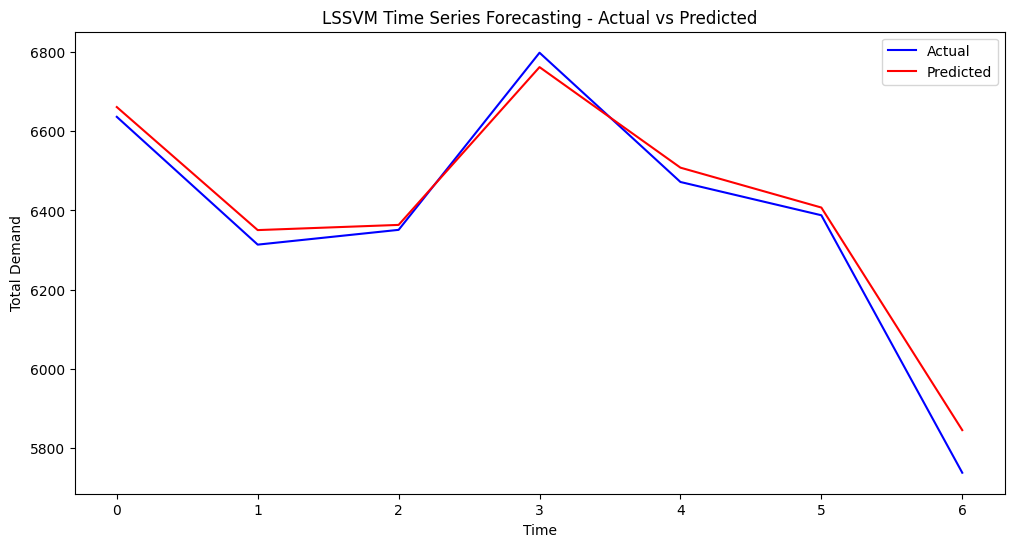

In [27]:
# fit and predict
lssvm_model = LSSVMRegressor(gamma=1, kernel='rbf', sigma=10)
lssvm_model.fit(X_train, y_train)

y_pred = lssvm_model.predict(testSetList[0]['X_test'])
getEvaluationMetrics(testSetList[0]['y_test'], y_pred)
getPlots(testSetList[0]['y_test'], y_pred, residuals = False)

## Hyperparameter tuning with gridsearch

In [28]:
param_grid = {
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'sigma': [0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    LSSVMRegressorWrapper(kernel='rbf'), 
    param_grid, cv=3,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("Best Parameters (Regression):", grid_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters (Regression): {'gamma': 0.001, 'sigma': 100}


# Validation 

In [29]:
from sklearn.linear_model import LinearRegression

# if using known values:
if(True):
    best_model = LSSVMRegressor(gamma=1, kernel='rbf', sigma=10)
    best_model.fit(X_train, y_train)

# train a correction model:
predictions = best_model.predict(X_train)
correction_model = LinearRegression().fit(predictions.reshape(-1, 1), y_train)

0
MAE: 42.47
Mean Squared Error (Regression): 2527.42
R^2 Score (Regression): 0.97
RMSE: 50.27
RRMSE: 0.0079
Nash–Sutcliffe efficiency coefficient: 0.97
Willmott index: 0.99
MAPE is: 0.69
ELM is :0.80


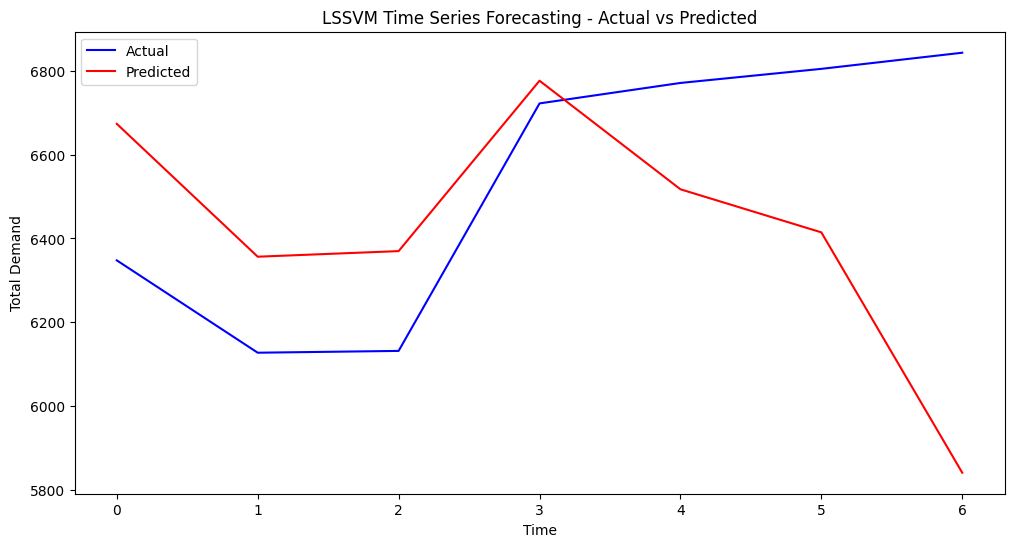

1
MAE: 31.59
Mean Squared Error (Regression): 1572.52
R^2 Score (Regression): 0.98
RMSE: 39.66
RRMSE: 0.0061
Nash–Sutcliffe efficiency coefficient: 0.98
Willmott index: 1.00
MAPE is: 0.48
ELM is :0.89


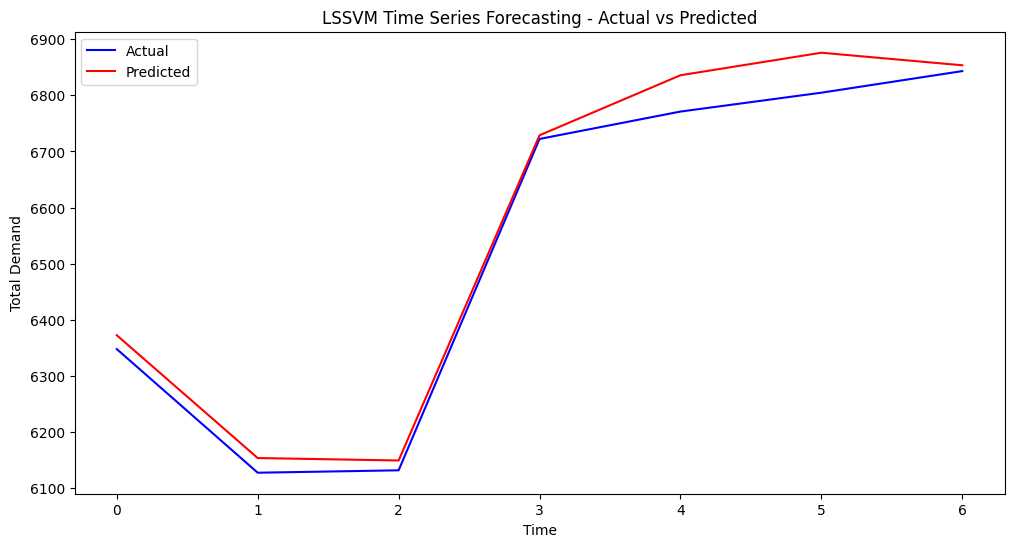

2
MAE: 37.04
Mean Squared Error (Regression): 1873.22
R^2 Score (Regression): 0.96
RMSE: 43.28
RRMSE: 0.0063
Nash–Sutcliffe efficiency coefficient: 0.96
Willmott index: 0.99
MAPE is: 0.55
ELM is :0.80


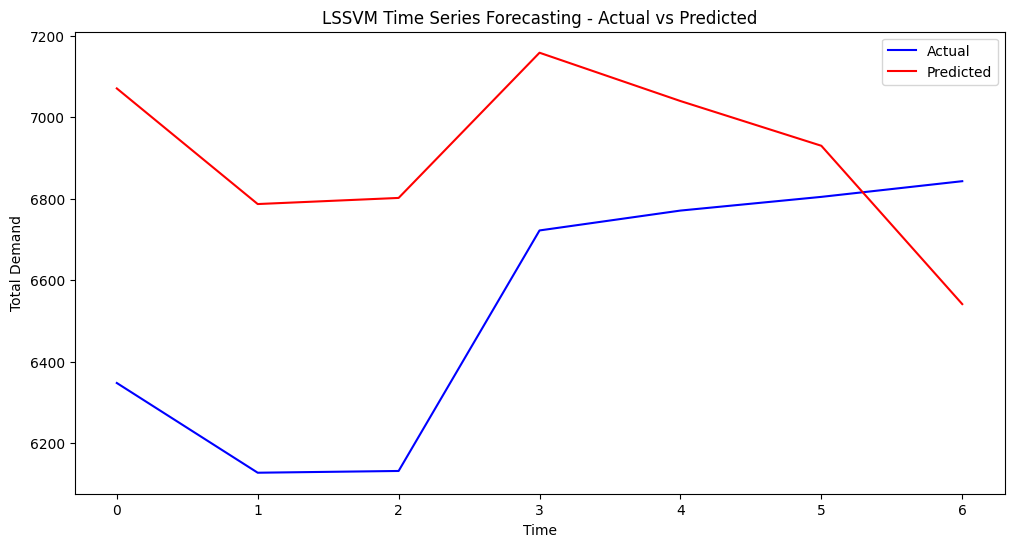

3
MAE: 37.90
Mean Squared Error (Regression): 2511.20
R^2 Score (Regression): 0.98
RMSE: 50.11
RRMSE: 0.0074
Nash–Sutcliffe efficiency coefficient: 0.98
Willmott index: 0.99
MAPE is: 0.56
ELM is :0.86


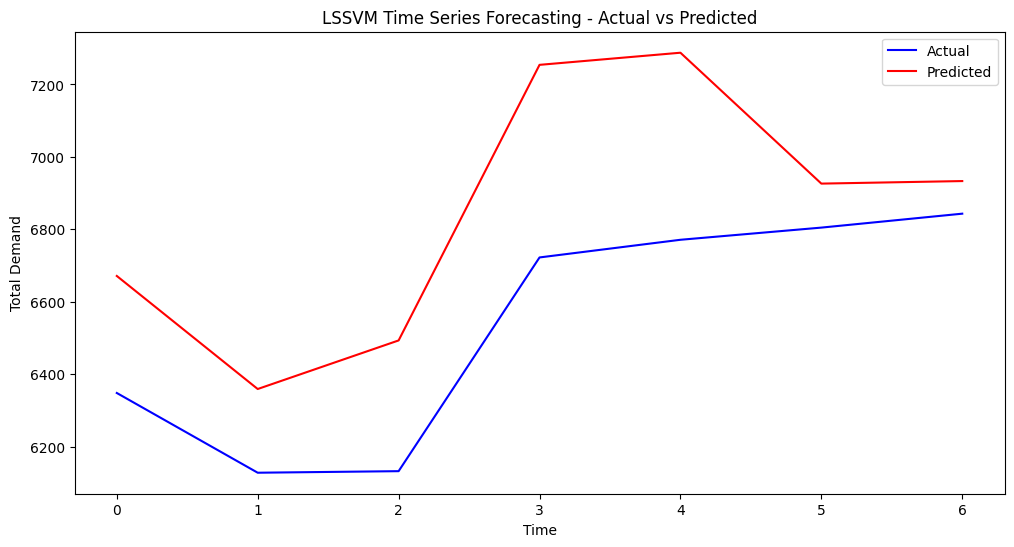

In [30]:
for i in range(0,4):
    print(i)
    y_pred = best_model.predict(testSetList[i]['X_test'])
    y_pred = correction_model.predict(y_pred.reshape(-1, 1))
    getEvaluationMetrics(testSetList[i]['y_test'], y_pred)
    getPlots(testSetList[1]['y_test'], y_pred)

# Other notes:

In [272]:
    # experiment more with lag features,
    # find more literature with existing lag features
    # provide reasoning
        # other people have done something
            # literature has shown that lag features are used in exisiting models
            # no access and SILO data lagging was not required in exisiting literature
        # experiment and testing
        # time constraints
    # discuss in future section
# Drop rows with NaN values introduced by lagging
